<a href="https://colab.research.google.com/github/mikaelbaymani/algo/blob/master/TriangularArbitrage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. Use multivariate Geometric BM to predict univ. GBM. Use one ML technique,
#    scikit learn only, on google colab.

In [ ]:
import numpy as np
import pandas as pd
import pandas_datareader as dr

In [ ]:
# Use case: Forecasting exchange rate JPY/EUR using triangle arbitrage.
#
#       USD
#      /   \
#     /     \
#    /       \
#  JPY_______EUR

In [ ]:
start_date = '2002-01-01'
end_date   = '2021-05-31'
# Roughly 22 working days in a month - use this as our analysis window.
moving_window = 22

In [ ]:
# Get currency exchange rate data.
JPY2USD = dr.data.DataReader( 'JPYUSD%3DX', data_source='yahoo', start=start_date, end=end_date )
USD2EUR = dr.data.DataReader( 'USDEUR%3DX', data_source='yahoo', start=start_date, end=end_date )
EUR2JPY = dr.data.DataReader( 'EURJPY%3DX', data_source='yahoo', start=start_date, end=end_date )

In [ ]:
# Rename column 'Adj Close'
JPY2USD.rename( columns = {'Adj Close': 'JPY/USD'}, inplace=True )
USD2EUR.rename( columns = {'Adj Close': 'USD/EUR'}, inplace=True )

In [ ]:
merged = pd.merge( JPY2USD['JPY/USD'], USD2EUR['USD/EUR'], on='Date' )

In [ ]:
# Calculate correlation, mean and standard deviation.
corr = merged['JPY/USD'].rolling( moving_window ).corr( merged['USD/EUR'] )
mu_1, sigma_1 = merged.rolling( moving_window ).mean().iloc[:, 0], merged.rolling( moving_window ).std().iloc[:, 0]
mu_2, sigma_2 = merged.rolling( moving_window ).mean().iloc[:, 1], merged.rolling( moving_window ).std().iloc[:, 1]

In [ ]:
# Create columns.
merged['corr'], merged['mu_1'], merged['mu_2'], merged['sigma_1'], merged['sigma2_1'] = corr, mu_1, mu_2, sigma_1, sigma_2
merged.drop( ['JPY/USD','USD/EUR'] , inplace=True, axis=1 ), merged.dropna( inplace=True )
print( merged.head )

<bound method NDFrame.head of                 corr      mu_1      mu_2   sigma_1  sigma2_1
Date                                                        
2003-12-30 -0.857416  0.009285  0.813051  0.000048  0.010130
2003-12-31 -0.777255  0.009292  0.811165  0.000039  0.009545
2004-01-01 -0.733682  0.009297  0.809692  0.000034  0.009453
2004-01-02 -0.723062  0.009303  0.808325  0.000033  0.009327
2004-01-05 -0.731076  0.009311  0.806527  0.000037  0.009214
...              ...       ...       ...       ...       ...
2021-05-25 -0.349337  0.009175  0.824601  0.000030  0.004773
2021-05-26 -0.465231  0.009171  0.824258  0.000026  0.004810
2021-05-27 -0.358136  0.009167  0.823941  0.000029  0.004843
2021-05-30 -0.264694  0.009162  0.823775  0.000030  0.004903
2021-06-01 -0.217726  0.009160  0.823479  0.000030  0.005045

[4496 rows x 5 columns]>


In [ ]:
rows, _ = merged.shape
y, X, t = EUR2JPY['Adj Close'].iloc[-rows:].to_numpy(), merged.to_numpy(), EUR2JPY.index[-rows:].to_numpy()
print( f"X.shape = {X.shape}, y.shape = {y.shape}, t.shape = {t.shape}" )

X.shape = (4496, 5), y.shape = (4496,), t.shape = (4496,)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [ ]:
# Split data
# ==========
# training data:   60%
# validation data: 20%
# testing data:    20%
X_training_and_testing, X_validation, y_training_and_testing, y_validation, t_training_and_testing, t_validation = train_test_split( X, y, t, test_size=1./5., shuffle=False )
X_training, X_testing, y_training, y_testing, t_training, t_testing = train_test_split( X_training_and_testing, y_training_and_testing, t_training_and_testing, test_size=1./4., shuffle=False )

In [ ]:
RMSE = lambda y, y_hat : np.sqrt( mean_squared_error( y, y_hat ) )

In [ ]:
min_rmse = None
best_deg = None
best_model = None

In [ ]:
for deg in [1, 2, 3, 4, 5]:

    # Find optimal model complexity (degree of polynomial).

    poly = PolynomialFeatures( degree = deg )
    X_training_poly = poly.fit_transform( X_training )

    model = LinearRegression().fit( X_training_poly, y_training )

    y_validation_pred = model.predict( poly.fit_transform( X_validation ) )
    rmse = RMSE( y_validation, y_validation_pred )

    if min_rmse is None or rmse < min_rmse:
        min_rmse = rmse
        best_deg = deg
        best_model = model

    print( f"degree={deg}, RMSE={rmse}" )

degree=1, RMSE=2.3431196080300243
degree=2, RMSE=2.258155766721632
degree=3, RMSE=3.6492476961412685
degree=4, RMSE=24.895285204222077
degree=5, RMSE=25.365514070871928


In [ ]:
import matplotlib.pyplot as plt

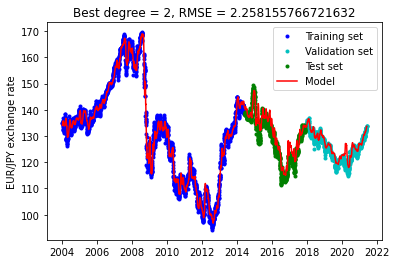

In [ ]:
plt.plot( t_training, y_training, 'b.' )
plt.plot( t_validation, y_validation, 'c.' )
plt.plot( t_testing, y_testing, 'g.' )
X_new = PolynomialFeatures( degree = best_deg ).fit_transform( X )
plt.plot( t, best_model.predict( X_new ), color='r' )
plt.legend( ['Training set', 'Validation set', 'Test set', 'Model'] )
plt.ylabel( 'EUR/JPY exchange rate' )
plt.title( f"Best degree = {best_deg}, RMSE = {min_rmse}" )
plt.show()

In [ ]:
X_testing_new = PolynomialFeatures( degree = best_deg ).fit_transform( X_testing )
print( f"RMSE: {RMSE( y_testing, best_model.predict( X_testing_new ) )}" )

RMSE: 3.596228997264477


In [ ]:
# Univ. GBM
print( f"mu: {best_model.predict( X_new ).mean()}" )
print( f"sigma: {best_model.predict( X_new ).std()}" )

mu: 130.969189088005
sigma: 14.782089385828122
